Data preparation and data clearning

In [160]:
import pandas as pd
import pyarrow.parquet as pq
import os

def read_parquet_files_to_dataframe(directory_path):
    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.endswith('.parquet')]
    
    # Initialize an empty list to hold DataFrames
    dataframes = []
    
    # Loop through the files and read each one into a DataFrame
    for file in files:
        file_path = os.path.join(directory_path, file)
        parquet_file = pq.ParquetFile(file_path)
        df = parquet_file.read().to_pandas()
        dataframes.append(df)
    
    # Concatenate all the DataFrames into a single DataFrame
    merged_dataframe = pd.concat(dataframes, ignore_index=True)
    
    return merged_dataframe

# Call the function
merged_dataframe = read_parquet_files_to_dataframe('tmdb/')
pd.set_option("max_colwidth", None)
pd.set_option('display.max_columns', None)

In [161]:
def extract_rating(ratings, source):
    for rating in ratings:
        if rating['Source'] == source:
            return rating['Value']
    return None

df = merged_dataframe[['id', 'title', 'release_date', "original_language" , 'spoken_languages', 'genres',
                       'production_companies',  'production_countries', 'runtime', 'status', 'Rated', 'adult',
                       'budget', 'revenue', 'BoxOffice', 'popularity', 'vote_average', 'vote_count',
                         'Awards', 'Ratings', 'Metascore', 'imdbRating',
       'imdbVotes']].copy()

df = df[df['status'].str.lower() == 'released']

df['Rotten_Tomatoes_Rating'] = df['Ratings'].apply(lambda x: extract_rating(x, 'Rotten Tomatoes')) 
df['genres'] = df['genres'].apply(lambda x: ', '.join([d['name'] for d in x]))
df['production_companies'] = df['production_companies'].apply(lambda x: ', '.join([d['name'] for d in x]))
df['production_countries'] = df['production_countries'].apply(lambda x: ', '.join([d['iso_3166_1'] for d in x]))
df['spoken_languages'] = df['spoken_languages'].apply(lambda x: ', '.join([d['iso_639_1'] for d in x]))
df['release_month'] = pd.to_datetime(df['release_date']).dt.month
df['release_year'] = pd.to_datetime(df['release_date']).dt.year

df.drop(['release_date', 'Ratings', 'status'], axis=1, inplace=True)

# Standardize column names
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.rename(columns={"popularity": "tmdb_popularity", "vote_average": "tmdb_vote_average",
                     "vote_count": "tmdb_vote_count", 'metascore': 'metacritic_rating',
                     "imdbrating": "imdb_rating", 'imdbvotes': 'imdb_votes'}, inplace=True)

df['boxoffice'] = df['boxoffice'].str.replace('$', '')
df['boxoffice'] = df['boxoffice'].str.replace(',', '')
df['boxoffice'] = pd.to_numeric(df['boxoffice'], errors='coerce')

df['rotten_tomatoes_rating'] = df['rotten_tomatoes_rating'].str.replace('%', '')

df['imdb_rating'] = pd.to_numeric(df['imdb_rating'], errors='coerce')
df['imdb_votes'] = df['imdb_votes'].str.replace(',', '')
df['imdb_votes'] = pd.to_numeric(df['imdb_votes'], errors='coerce')
df['rotten_tomatoes_rating'] = pd.to_numeric(df['rotten_tomatoes_rating'], errors='coerce')
df['metacritic_rating'] = pd.to_numeric(df['metacritic_rating'], errors='coerce')


categorical_vars = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_vars:
    df[c] = df[c].str.lower()

df


,id,title,original_language,spoken_languages,genres,production_companies,production_countries,runtime,rated,adult,budget,revenue,boxoffice,tmdb_popularity,tmdb_vote_average,tmdb_vote_count,awards,metacritic_rating,imdb_rating,imdb_votes,rotten_tomatoes_rating,release_month,release_year
0,2501,the bourne identity,en,"en, fr, de, nl, it","action, drama, mystery, thriller","universal pictures, hypnotic, kalima productions, stillking films, the kennedy/marshall company","us, de, cz",119,pg-13,False,60000000,214034224,121661683.00,37.01,7.46,8631,3 wins & 6 nominations,68.00,7.80,565180.00,84.00,6,2002
1,2502,the bourne supremacy,en,"en, ru, de, it","action, drama, thriller","universal pictures, the kennedy/marshall company, hypnotic, motion picture theta produktionsgesellschaft, ludlum entertainment","de, us",108,pg-13,False,75000000,288500217,176241941.00,25.65,7.32,6987,5 wins & 22 nominations,73.00,7.70,478645.00,82.00,7,2004
2,2503,the bourne ultimatum,en,"en, fr, ar, ru, es","action, drama, mystery, thriller","universal pictures, the kennedy/marshall company, ludlum entertainment, motion picture beta produktionsgesellschaft, bourne again, kanzaman services, peninsula films, studio babelsberg","fr, de, es, us",115,pg-13,False,70000000,442824138,227471070.00,26.90,7.42,7137,won 3 oscars. 29 wins & 42 nominations total,85.00,8.00,649755.00,92.00,8,2007
3,2516,our mother's house,en,en,"drama, thriller","filmways pictures, heron film productions, metro-goldwyn-mayer british studios",gb,105,approved,False,800000,0,NaN,5.74,7.11,35,nominated for 1 bafta award1 win & 3 nominations total,NaN,7.20,2174.00,60.00,9,1967
4,2517,nobody knows,ja,ja,drama,"engine film, c-style, bandai visual, tv man union, cinequanon",jp,141,pg-13,False,0,0,684118.00,15.48,7.99,439,13 wins & 10 nominations,88.00,8.00,30094.00,92.00,8,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,196,back to the future part iii,en,en,"adventure, comedy, science fiction","universal pictures, amblin entertainment",us,119,pg,False,40000000,244527583,88277583.00,31.72,7.50,9687,5 wins & 11 nominations,55.00,7.40,468495.00,80.00,5,1990
1936,197,braveheart,en,"en, fr, la, gd","action, drama, history, war","icon entertainment international, the ladd company, b.h. finance c.v.",us,177,r,False,72000000,213216216,75609945.00,42.17,7.93,9355,won 5 oscars. 34 wins & 34 nominations total,68.00,8.30,1069827.00,76.00,5,1995
1937,198,to be or not to be,en,"en, de","comedy, war",united artists,us,99,passed,False,1200000,1500000,3270000.00,11.81,7.89,630,nominated for 1 oscar. 2 wins & 2 nominations total,86.00,8.20,40902.00,96.00,3,1942
1938,199,star trek: first contact,en,en,"science fiction, action, adventure, thriller",paramount,us,111,pg-13,False,46000000,150000000,92027888.00,27.22,7.29,1593,nominated for 1 oscar. 8 wins & 21 nominations total,71.00,7.60,130183.00,93.00,11,1996


ADJUST REVENUE AND BUDGET AND CREATE ROI

In [164]:
cpi_data = pd.read_csv('US_inflation_rates.csv', names=['date', 'CPI'], skiprows=1)  # Your CPI data

# Convert the 'date' column to datetime format and extract the year and month
cpi_data['date'] = pd.to_datetime(cpi_data['date'], format='%Y-%m-%d')
cpi_data['year'] = cpi_data['date'].dt.year
cpi_data['month'] = cpi_data['date'].dt.month

# Merge the datasets on year and month
merged_data = pd.merge(df, cpi_data, left_on=['release_year', 'release_month'], right_on=['year', 'month'], how='left')

# filter movies with unknown budget or revenue
merged_data = merged_data[(merged_data['budget'] != 0) & (merged_data['revenue'] != 0)]

# Find the most recent year and month in the dataset
max_year = cpi_data['year'].max()
max_month = cpi_data[cpi_data['year'] == max_year]['month'].max()

# Get the CPI value for the target year and month
target_cpi = cpi_data[(cpi_data['year'] == max_year) & (cpi_data['month'] == max_month)]['CPI'].values[0]

# Calculate the adjustment factor
merged_data['adjustment_factor'] = target_cpi / merged_data['CPI']

# Adjust the budget and revenue columns
merged_data['adjusted_budget'] = merged_data['budget'] * merged_data['adjustment_factor']
merged_data['adjusted_revenue'] = merged_data['revenue'] * merged_data['adjustment_factor']

# Set the float format to display the entire number
pd.options.display.float_format = '{:.2f}'.format

roi_df = merged_data[merged_data['release_year'] >= 1947].drop(['year', 'month', 'date', 'CPI', 'adjustment_factor', 'budget', 'revenue', 'boxoffice'], axis=1)
roi_df['ROI'] = ((roi_df['adjusted_revenue'] - roi_df['adjusted_budget']) / roi_df['adjusted_budget']) * 100

roi_df

,id,title,original_language,spoken_languages,genres,production_companies,production_countries,runtime,rated,adult,tmdb_popularity,tmdb_vote_average,tmdb_vote_count,awards,metacritic_rating,imdb_rating,imdb_votes,rotten_tomatoes_rating,release_month,release_year,adjusted_budget,adjusted_revenue,ROI
0,2501,the bourne identity,en,"en, fr, de, nl, it","action, drama, mystery, thriller","universal pictures, hypnotic, kalima productions, stillking films, the kennedy/marshall company","us, de, cz",119,pg-13,False,37.01,7.46,8631,3 wins & 6 nominations,68.00,7.80,565180.00,84.00,6,2002,101505902.00,362095616.12,256.72
1,2502,the bourne supremacy,en,"en, ru, de, it","action, drama, thriller","universal pictures, the kennedy/marshall company, hypnotic, motion picture theta produktionsgesellschaft, ludlum entertainment","de, us",108,pg-13,False,25.65,7.32,6987,5 wins & 22 nominations,73.00,7.70,478645.00,82.00,7,2004,120508064.52,463554703.51,284.67
2,2503,the bourne ultimatum,en,"en, fr, ar, ru, es","action, drama, mystery, thriller","universal pictures, the kennedy/marshall company, ludlum entertainment, motion picture beta produktionsgesellschaft, bourne again, kanzaman services, peninsula films, studio babelsberg","fr, de, es, us",115,pg-13,False,26.90,7.42,7137,won 3 oscars. 29 wins & 42 nominations total,85.00,8.00,649755.00,92.00,8,2007,102418150.21,647903272.61,532.61
12,2539,spanglish,en,"es, en",comedy,"gracie films, columbia pictures",us,130,pg-13,False,16.82,6.00,1185,5 wins & 15 nominations,48.00,6.40,87369.00,54.00,12,2004,126798539.38,87239561.77,-31.20
14,2565,joe versus the volcano,en,en,"comedy, romance","amblin entertainment, warner bros. pictures",us,102,pg,False,14.29,5.67,468,1 nomination,45.00,5.90,39040.00,66.00,3,1990,59067068.43,93099767.24,57.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,194,amélie,fr,"fr, ru","comedy, romance","france 3 cinéma, claudie ossard productions, mmc independent, tapioca films, sofica sofinergie 5, victoires productions, canal+, filmstiftung nordrhein-westfalen, union générale cinématographique (ugc), miramax","fr, de",122,r,False,32.44,7.91,10767,nominated for 5 oscars. 59 wins & 74 nominations total,69.00,8.30,777290.00,89.00,4,2001,17224546.49,299572678.15,1639.22
1935,196,back to the future part iii,en,en,"adventure, comedy, science fiction","universal pictures, amblin entertainment",us,119,pg,False,31.72,7.50,9687,5 wins & 11 nominations,55.00,7.40,468495.00,80.00,5,1990,94141285.82,575503527.08,511.32
1936,197,braveheart,en,"en, fr, la, gd","action, drama, history, war","icon entertainment international, the ladd company, b.h. finance c.v.",us,177,r,False,42.17,7.93,9355,won 5 oscars. 34 wins & 34 nominations total,68.00,8.30,1069827.00,76.00,5,1995,143830059.17,425929180.05,196.13
1938,199,star trek: first contact,en,en,"science fiction, action, adventure, thriller",paramount,us,111,pg-13,False,27.22,7.29,1593,nominated for 1 oscar. 8 wins & 21 nominations total,71.00,7.60,130183.00,93.00,11,1996,88069855.07,287184310.02,226.09


In [135]:
cpi_data = pd.read_csv('US_inflation_rates.csv', names=['date', 'CPI'], skiprows=1)  # Your CPI data

# Convert the 'date' column to datetime format and extract the year and month
cpi_data['date'] = pd.to_datetime(cpi_data['date'], format='%Y-%m-%d')
cpi_data['year'] = cpi_data['date'].dt.year
cpi_data['month'] = cpi_data['date'].dt.month

# Merge the datasets on year and month
merged_data = pd.merge(df, cpi_data, left_on=['release_year', 'release_month'], right_on=['year', 'month'], how='left')

# Get the CPI value for the target year and month (assuming the target year and month is the most recent in the dataset)
target_cpi = cpi_data[(cpi_data['year'] == cpi_data['year'].max()) & (cpi_data['month'] == cpi_data['month'].max())]['CPI'].values[0]

# Calculate the adjustment factor
merged_data['Adjustment Factor'] = target_cpi / merged_data['CPI']

# Adjust the budget and revenue columns
merged_data['Adjusted Budget'] = merged_data['budget'] * merged_data['Adjustment Factor']
merged_data['Adjusted Revenue'] = merged_data['revenue'] * merged_data['Adjustment Factor']

merged_data

IndexError: index 0 is out of bounds for axis 0 with size 0

In [39]:
#value_counts = df["Production"].value_counts()
#value_counts
null_count = df['BoxOffice'].isnull().sum()
null_count

0

In [116]:
import re

pattern = {'oscar_won': re.compile(r'won (\d+) oscar', re.IGNORECASE),
           'oscar_nominated': re.compile(r'nominated for (\d+) oscar', re.IGNORECASE),
           'bafta_won': re.compile(r'won (\d+) bafta', re.IGNORECASE),
           'bafta_nominated': re.compile(r'nominated for (\d+) bafta', re.IGNORECASE),
           'awards_won': re.compile(r'(\d+)\s*win', re.IGNORECASE),
           'awards_nominated': re.compile(r'(\d+)\s*nomination', re.IGNORECASE)}
df['awards'] = df['awards'].str.replace('n/a', '')
for k, v in pattern.items():
# Use str.extract() to extract the number of Oscars won
    df[k] = df['awards'].str.extract(v).fillna(0).astype(int)

# Split the genres column into a DataFrame of dummies
genre_dummies = df['genres'].str.get_dummies(sep=', ')

# Now 'genre_dummies' is a DataFrame with separate columns for each genre

# Optionally, if you want to merge this back with your original DataFrame:
df = pd.concat([df, genre_dummies], axis=1)
df.drop(['genres'], axis=1, inplace=True)
df


,id,title,original_language,spoken_languages,production_companies,production_countries,runtime,rated,adult,budget,revenue,boxoffice,tmdb_popularity,tmdb_vote_average,tmdb_vote_count,awards,metacritic_rating,imdb_rating,imdb_votes,rotten_tomatoes_rating,release_month,release_year,oscar_won,oscar_nominated,bafta_won,bafta_nominated,awards_won,awards_nominated,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,history,horror,music,mystery,romance,science fiction,thriller,tv movie,war,western,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,history,horror,music,mystery,romance,science fiction,thriller,tv movie,war,western
0,2501,the bourne identity,en,"en, fr, de, nl, it","universal pictures, hypnotic, kalima productions, stillking films, the kennedy/marshall company","us, de, cz",119,pg-13,False,60000000,214034224,121661683.0,37.011,7.463,8631,3 wins & 6 nominations,68.0,7.8,565180.0,84.0,6,2002,0,0,0,0,3,6,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
1,2502,the bourne supremacy,en,"en, ru, de, it","universal pictures, the kennedy/marshall company, hypnotic, motion picture theta produktionsgesellschaft, ludlum entertainment","de, us",108,pg-13,False,75000000,288500217,176241941.0,25.647,7.315,6987,5 wins & 22 nominations,73.0,7.7,478645.0,82.0,7,2004,0,0,0,0,5,22,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,2503,the bourne ultimatum,en,"en, fr, ar, ru, es","universal pictures, the kennedy/marshall company, ludlum entertainment, motion picture beta produktionsgesellschaft, bourne again, kanzaman services, peninsula films, studio babelsberg","fr, de, es, us",115,pg-13,False,70000000,442824138,227471070.0,26.899,7.421,7137,won 3 oscars. 29 wins & 42 nominations total,85.0,8.0,649755.0,92.0,8,2007,3,0,0,0,29,42,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
3,2516,our mother's house,en,en,"filmways pictures, heron film productions, metro-goldwyn-mayer british studios",gb,105,approved,False,800000,0,NaN,5.744,7.114,35,nominated for 1 bafta award1 win & 3 nominations total,NaN,7.2,2174.0,60.0,9,1967,0,0,0,1,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,2517,nobody knows,ja,ja,"engine film, c-style, bandai visual, tv man union, cinequanon",jp,141,pg-13,False,0,0,684118.0,15.482,7.985,439,13 wins & 10 nominations,88.0,8.0,30094.0,92.0,8,2004,0,0,0,0,13,10,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838,196,back to the future part iii,en,en,"universal pictures, amblin entertainment",us,119,pg,False,40000000,244527583,88277583.0,31.724,7.500,9687,5 wins & 11 nominations,55.0,7.4,468495.0,80.0,5,1990,0,0,0,0,5,11,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1839,197,braveheart,en,"en, fr, la, gd","icon entertainment international, the ladd company, b.h. finance c.v.",us,177,r,False,72000000,213216216,75609945.0,42.167,7.933,9355,won 5 oscars. 34 wins & 34 nominations total,68.0,8.3,1069827.0,76.0,5,1995,5,0,0,0,34,34,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
1840,198,to be or not to be,en,"en, de",united artists,us,99,passed,False,1200000,1500000,3270000.0,11.815,7.889,630,nominated for 1 oscar. 2 wins & 2 nominations total,86.0,8.2,40902.0,96.0,3,1942,0,1,0,0,2,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1841,199,star trek: first contact,en,en,paramount,us,111,pg-13,False,46000000,150000000,92027888.0,27.217,7.294,1593,nominated for 1 oscar. 8 wins & 21 nominations total,71.0,7.6,130183.0,93.0,11,1996,0,1,0,0,8,21,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,

EDA

ways to create new features:
spoken_languages - or hot encoding or other variants
production_companies
production_countries

In [123]:
eda_df = df.copy()
eda_df.to_csv('eda.csv', index=False)

<Axes: ylabel='Frequency'>

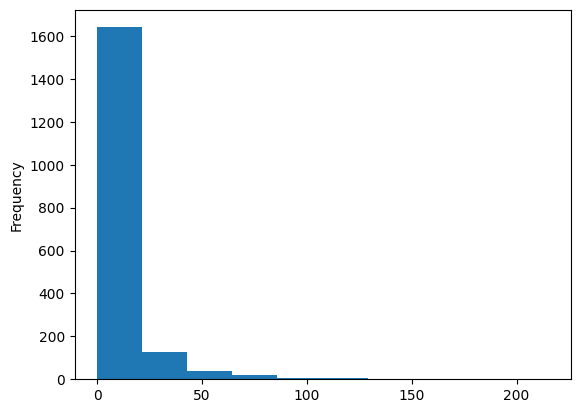

In [121]:
eda_df['awards_won'].plot(kind="hist")

In [120]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
le = LabelEncoder()

# Fit and transform the original_language column
eda_df['language_label'] = le.fit_transform(eda_df['original_language'])
eda_df[['language_label', 'original_language']]

,language_label,original_language
0,8,en
1,8,en
2,8,en
3,8,en
4,18,ja
...,...,...
1838,8,en
1839,8,en
1840,8,en
1841,8,en


In [ ]:
from sklearn.ensemble import RandomForestRegressor
#feature importance analysis
# decision tree model

dtr = RandomForestRegressor()# DecisionTreeRegressor()
dtr.fit(x_train,y_train)

feat_importances = pd.Series(dtr.feature_importances_, index=x_train.columns)
feat_importances.nlargest(len(x_train.columns)).plot(kind='barh')
